In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import NeuroPixel
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [3]:
# raw data location
data_path = "rawDataSample.bin"

# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 22
file_directory = 'results/'
file_name = 'ProcessedSpikesNeuropixel'

In [4]:
Probe = NeuroPixel(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name,
                file_directory_name=file_directory)

In [5]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 30000
# Localization On
# Not Masking any Channels
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60.0
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 50000
# Analysing 50000 frames; from -42 to 50055
# Analysing 50000 frames; from 49958 to 100055
# Analysing 50000 frames; from 99958 to 150055
# Analysing 50000 frames; from 149958 to 200055
# Analysing 50000 frames; from 199958 to 250055
# Analysing 50000 frames; from 249958 to 300055
# Analysing 50000 frames; from 299958 to 350055
# Analysing 50000 frames; from 349958 to 400055
# Analysing 50000 frames; from 399958 to 450055
# Analysing 50000 frames; from 449958 to 500055
# Analysing 50000 frames; from 499958 to 550055
# Analysing 50000 frames; from 549958 to 600055
# Analysing 50000 frames; from 599958 to 650055
# Analysing 50000 frames; from 649958 to 700055
# Analysing 50000 frames; from 699958 to 750055
# Analysing 50000 frames; from 749958 to 

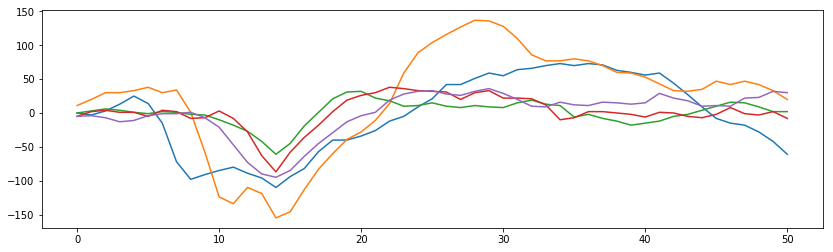

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [14, 18, 77, 90, 156]:
    plt.plot(H.spikes['Shape'][i])
plt.show()

In [15]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]
embedding_size = (int)(length//4)

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

electrode_data_vp = np.load('electrode_train.npy')

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(112625, 51)


In [16]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (90100, 51)
Test Datasize: (22525, 51)


In [57]:
from sklearn.decomposition import PCA


def find_scaled_mse(original, recons, params='all'):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        se = se/np.std(original[i, :])
        mse.append(np.mean(se))
    print(params, np.median(mse))
    mse = np.array(mse)
    return mse
    

# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def plot_correlation(dict_of_outputs):
    plt.figure(figsize=(14,8))

    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    size = len(keys)/2 *100 + 20
    
    for i in range(len(keys)):
        plt.subplot(size+i)
        plt.scatter(electrode_data_test, vals[i], s=0.5)
        plt.title(str(keys[i]))
    plt.show()

# dict_of_outputs = {'AE_2': [<list>], 'AE_4':[<list>], ... 'PCA':[<list>], 'Original': [<list>]}

def gen_boxplots(dict_of_outputs):
    fig = plt.figure(1, figsize=(10,10))
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    ax = fig.add_subplot(111)
    ax.boxplot(vals, showfliers=True, notch=False)
    ax.grid()
    ax.set_xticklabels(keys)
    plt.show()

# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def find_correlation_coeff(dict_of_outputs, plot = True):
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    corrs = {}
    for i in range(len(keys)):
        corrs[keys[i]] = [np.corrcoef(electrode_data_test[j],vals[i][j])[0,1] 
                             for j in range(electrode_data_test.shape[0])]
    holder = []
    for i in keys:
        print(i, np.median(corrs[i]))
        holder.append((i, np.median(corrs[i])))
    if plot:
        gen_boxplots(corrs)
    else:
        return holder

def comp_pca(components):
    pca = PCA(n_components=components)
    pca.fit(electrode_data_vp)
    e_data_pca = pca.transform(electrode_data_test)
    e_data_proj = pca.inverse_transform(e_data_pca)
    return e_data_proj

def get_network_output(model, embedding):
    enc_final = np.zeros([electrode_data_test.shape[0], embedding])
    out_final = np.zeros([electrode_data_test.shape[0], 51])

    for i in range(electrode_data_test.shape[0]):
        data = electrode_data_test[i, :]
        data = torch.from_numpy(data).float()

        enc, o = model.forward(data)
        o = (o.data).cpu().numpy()
        enc = (enc.data).cpu().numpy()

        enc_final[i, :] = enc[:]
        out_final[i, :] = o[:]
    
    return enc_final, out_final

In [51]:
# input -> 100 -> 50 -> 25 -> 12 -> emb -> 12 -> 25 -> 50 -> 100 -> input

class autoencoder_sdeep(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_sdeep, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 80),
                                     activation_layer,
                                     nn.Linear(80, 60),
                                     activation_layer,
                                     nn.Linear(60, 45),
                                     activation_layer,
                                     nn.Linear(45, 25),
                                     activation_layer,
                                     nn.Linear(25, 12),
                                     activation_layer,
                                     nn.Linear(12, 8),
                                     activation_layer,
                                     nn.Linear(8, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 8),
                                     activation_layer,
                                     nn.Linear(8, 12),
                                     activation_layer,
                                     nn.Linear(12, 25),
                                     activation_layer,
                                     nn.Linear(25, 45),
                                     activation_layer,
                                     nn.Linear(45, 60),
                                     activation_layer,
                                     nn.Linear(60, 80),
                                     activation_layer,
                                     nn.Linear(80, 100),
                                     activation_layer,
                                     nn.Linear(100, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [52]:
ae_1 = torch.load('models/final_models/ae_6_2.pt', map_location=lambda storage, loc: storage)

AE 0.8406280485484746
PCA 0.7757541663063398


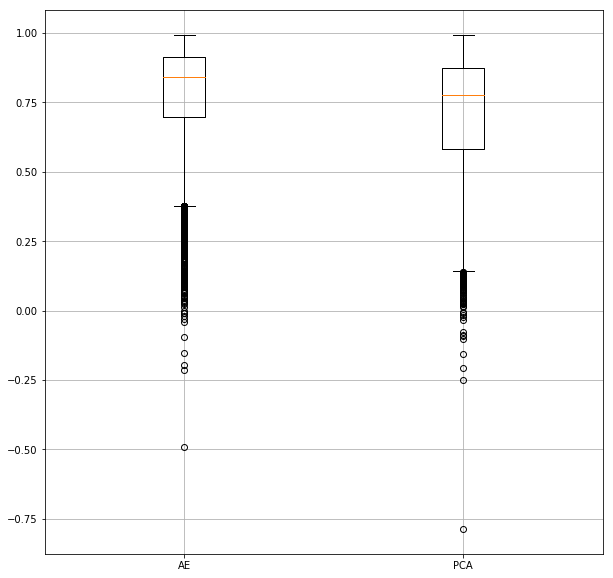

In [53]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 11.07013693660355
AE 7.7232889040165515


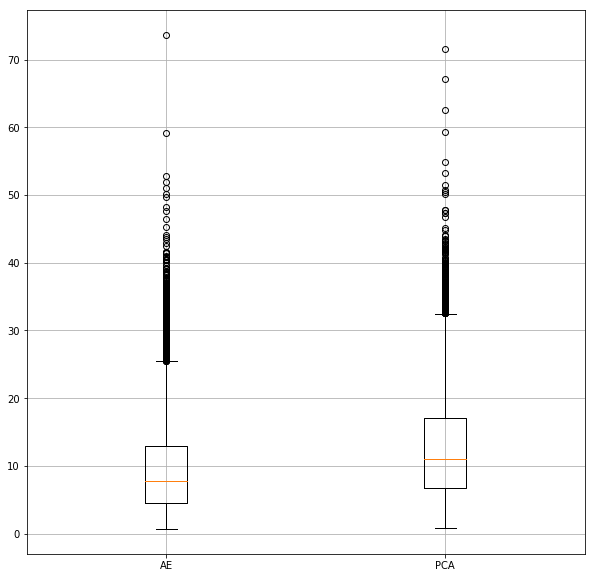

In [54]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

In [62]:
def relative_improvement(ae_data, pca_data, baseline):
    ae_improv = np.abs((np.median(baseline) - np.median(ae_data))/np.median(baseline))
    ae_improv *= 100

    pca_improv = np.abs((np.median(baseline) - np.median(pca_data))/np.median(baseline))
    pca_improv *= 100

    print("Baseline Value: ", np.median(baseline))
    print("AE Value: ", np.median(ae_data))
    print("PCA Value: ", np.median(pca_data))
    print('\n AE improvement: ', ae_improv)
    print('PCA improvement: ', pca_improv)

In [58]:
# Correlation Coefficient Improvement

d = {'AE': out_ae, 'PCA': out_pca, 'Baseline': comp_pca(0)}
meds = find_correlation_coeff(d, plot=False)

relative_improvement(meds[0][1], meds[1][1], meds[2][1])

AE 0.8406280485484746
PCA 0.7757541663063398
Baseline 0.7598027573060795

 AE improvement:  10.637667534790928
PCA improvement:  2.099414466040742


In [63]:
out_base = np.zeros((electrode_data_test.shape[0], 51))
for i in range(51):
    out_base[:, i] = np.mean(electrode_data_test[:, i])
baseline = find_scaled_mse(electrode_data_test, out_base, 'Baseline')

Baseline 11.936449016238278


In [64]:
# MSE Improvement
relative_improvement(ae_mse, pca_mse, baseline)

Baseline Value:  11.936449016238278
AE Value:  7.7232889040165515
PCA Value:  11.07013693660355

 AE improvement:  35.29659538184403
PCA improvement:  7.257703513467044
